# Extract and align data from Onix, Harp, Sleap, and photometry

### Setup

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import harp

from harp_resources import process, utils
from sleap import load_and_process as lp

ModuleNotFoundError: No module named 'aeon.io'

In [6]:
from harp_resources import utils

ModuleNotFoundError: No module named 'aeon.io'

# Extracting Noras data

In [2]:
photometry_path = '/Volumes/RanczLab/Nora_Cohort1_training/Training_day4/B6J2717-2024-11-28T09-37-55/photometry'
data_path = '/Volumes/RanczLab/Nora_Cohort1_training/Training_day4/B6J2717-2024-11-28T09-37-55/'

photometry_path = '/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/photometry_processed'
data_path = '/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/'

h1_datafolder = data_path+'HarpDataH1'
h2_datafolder = data_path+'HarpDataH2'

In [3]:
pd.read_csv(str(photometry_path)+'/Processed_fluorescence.csv') #Processed_fluorescence.csv #Fluorescence.csv

,TimeStamp,filtered_470,filtered_560,filtered_410,470_dfF,560_dfF,410_dfF,z_470,z_560,z_410,Time,mouseID,Area,Sex
0,15.011116,43.050089,106.269,11.223983,-1.475054,2.003618,-2.043206,-1.317243,1.204203,-2.942154,2024-12-05 11:54:33.011116,B6J2717,V2M,M
1,15.044446,43.024373,106.314,11.221655,-1.533527,2.047336,-2.063057,-1.368800,1.224585,-2.970065,2024-12-05 11:54:33.044446,B6J2717,V2M,M
2,15.077781,42.998491,106.036,11.216651,-1.592379,1.781016,-2.106259,-1.420692,1.100389,-3.030822,2024-12-05 11:54:33.077781,B6J2717,V2M,M
3,15.111111,42.972916,105.926,11.209201,-1.650530,1.675952,-2.170807,-1.471964,1.051392,-3.121603,2024-12-05 11:54:33.111111,B6J2717,V2M,M
4,15.144448,42.948724,105.630,11.202558,-1.705516,1.392350,-2.228321,-1.520444,0.919139,-3.202491,2024-12-05 11:54:33.144448,B6J2717,V2M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72521,2432.049671,42.932277,87.326,10.357888,2.267982,-0.266080,-0.029427,1.904949,0.165581,-0.105458,2024-12-05 12:34:50.049671,B6J2717,V2M,M
72522,2432.083003,42.882033,87.165,10.352688,2.148297,-0.449876,-0.079582,1.803550,0.093548,-0.169254,2024-12-05 12:34:50.083003,B6J2717,V2M,M
72523,2432.116334,42.833270,87.437,10.349463,2.032139,-0.139148,-0.110686,1.705140,0.215329,-0.208818,2024-12-05 12:34:50.116334,B6J2717,V2M,M
72524,2432.149659,42.790757,87.865,10.347816,1.930871,0.349747,-0.126554,1.619344,0.406937,-0.229001,2024-12-05 12:34:50.149659,B6J2717,V2M,M


In [4]:
# from andrew:
#Changed didgital output file
h1_reader = harp.create_reader('harp_resources/h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('harp_resources/h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
photometry_reader = utils.PhotometryReader("Processed_fluorescence")
video_reader = utils.Video("VideoData1")
onix_digital_reader = utils.TimestampedCsvReader("OnixDigital", columns=["Clock", "HubClock", 
                                                                         "DigitalInputs0",
                                                                         "DigitalInputs1",
                                                                         "DigitalInputs2",
                                                                         "DigitalInputs3",
                                                                         "DigitalInputs4",
                                                                         "DigitalInputs5"
                                                                         "DigitalInputs6",
                                                                         "DigitalInputs7",
                                                                         "DigitalInputs8",
                                                                         "Buttons"])
onix_harp_reader = utils.TimestampedCsvReader("OnixHarp", columns=["Clock", "HubClock", "HarpTime"])

NameError: name 'utils' is not defined

In [155]:
# read metadata
session_settings = utils.load_2(session_data_reader, data_path)

print(session_settings.iloc[0]['metadata'].blocks[0].haltProtocol)

DotMap(randomDelay=1.5, minumumDelay=0.1, haltGain=0.0, haltMotorGain=1.0, haltTime=2.0)


In [156]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
camera_triggers = utils.load_harp(h1_reader.Cam0Event, h1_datafolder)
experiment_events = utils.load_2(experiment_events_reader, root_folder)
video_data = utils.load_2(video_reader, root_folder)

/Volumes/RanczLab/Nora_Cohort1_training/Visual_mismatch_day1/B6J2717/HarpDataH1/HarpDataH1_46_*.bin


OverflowError: Python integer 4217616 out of bounds for uint8

# Bulk extraction
## old data

In [2]:
#data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/2024-08-12T16-51-16_B3M3')
#photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_120824/photometry/B3M3_MMclosed&Regular_day1/2024_08_12-18_57_17')


In [163]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import pandas as pd
import harp

from harp_resources import process, utils
from sleap import load_and_process as lp

In [493]:
import os

rootdir = '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_070824'
rootdir = '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824'
#rootdir = '/Volumes/RanczLab/20240730_Mismatch_Experiment/GRAB_MMclosed-and-Regular_220824'

#initialize sets to ensure uniqueness
data_paths_set = set()
photometry_paths_set = set()

data_paths = []
photometry_paths = []

for dirpath, subdirs, files in os.walk(rootdir):
    #data paths
    if 'ExperimentEvents' in dirpath:
        trimmed_path = dirpath[:-17]
        if trimmed_path not in data_paths_set:
            data_paths_set.add(trimmed_path)
            data_paths.append(trimmed_path)

    #photometry paths
    for x in files:
        if 'Processed_fluorescence.csv' in x:
            if dirpath not in photometry_paths_set:
                photometry_paths_set.add(dirpath)
                photometry_paths.append(dirpath)




In [494]:
photometry_paths

['/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T08-22-12_B2M5/photometry',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T09-20-54_B2M4/photometry',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T10-05-26_B3M3/photometry',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T11-01-22_B3M1/photometry',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T12-03-57_B3M2/photometry']

In [495]:
data_paths

['/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T08-22-12_B2M5',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T09-20-54_B2M4',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T10-05-26_B3M3',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T11-01-22_B3M1',
 '/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T12-03-57_B3M2']

In [167]:
def run_extraction_makeh5(data_path, photometry_path, make_h5 = False, eyes = False):
    print(f'\n Running extraction for {data_path.split('/')[-1][20:]} for session {data_path.split('/')[-2]}')
    #data_path = Path(data_path)
    #photometry_path = Path(photometry_path)
    SessionSettings = utils.read_SessionSettings(Path(data_path), print_contents=True)
    conversions = process.calculate_conversions_second_approach(Path(data_path), Path(photometry_path), verbose=False)
    streams = utils.load_registers(Path(data_path))

    Photometry = utils.read_fluorescence(Path(photometry_path))
    Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])
    
    OnixAnalogClock = utils.read_OnixAnalogClock(Path(data_path))
    OnixAnalogData = utils.read_OnixAnalogData(Path(data_path), binarise=True)
    ExperimentEvents = utils.read_ExperimentEvents(Path(data_path)) 
    
    photodiode_series = pd.Series(OnixAnalogData[:,0], index=conversions['onix_to_harp_timestamp'](OnixAnalogClock))

    print('Adding Photometry, Eye Movements and Photodiode to the streams')
    streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'], index_column_name='HARP Timestamps')
    streams = process.add_stream(streams, 'ONIX', photodiode_series, 'Photodiode')
    
    
    _ = process.get_timepoint_info(streams, print_all=True)
    resampled_streams = process.pad_and_resample(streams, resampling_period='1 ms', method='linear')
    _ = process.get_timepoint_info(resampled_streams, print_all=True)

    print('Applying linear and angular conversion to Optical tracking sensor streams (cm / sec and degrees / sec)')
    resampled_streams['H1']['OpticalTrackingRead0X(46)'] = process.running_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0X(46)']*100)
    resampled_streams['H1']['OpticalTrackingRead0Y(46)'] = process.rotation_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0Y(46)'])
        
    print('Streams are extracted and can be used or made to h5')
    if make_h5:
        process.save_streams_as_h5(Path(data_path), resampled_streams, streams_to_save_pattern, SessionSetting)

In [168]:
data_path, resampled_streams, streams_to_save_pattern =run_extraction_makeh5(data_paths[1], photometry_paths[1]) 



 Running extraction for B2M4 for session G8_MMclosed-and-open_070824
{
    "seconds": 685478.300256,
    "value": {
        "motorSettings": {
            "nominalPulseInterval": 200,
            "initialPulseInterval": 200,
            "pulseStepInterval": 2,
            "pulsePeriod": 10
        },
        "blocks": [
            {
                "alias": "LinearMismatch",
                "playbackFilePath": "",
                "blockGainModifier": 1.0,
                "flowXToVisualGain": 0.0008,
                "flowYToVisualGain": 0.0,
                "rotaryToVisualGain": 0.0,
                "playbackToVisualGain": 0.0,
                "stimulus": {
                    "type": 0,
                    "spatialFrequency": 28.8,
                    "offset1": -90.0,
                    "extent1": 180.0,
                    "offset2": 90.0,
                    "extent2": 180.0,
                    "path": ""
                },
                "flowXToMotorGain": 0.0,
              

/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:153: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()



Shape of OnixAnalogClock == [250166000] shape of OnixAnalogFrameCount == [250168300].
Cutting 2300 values from the beginning of OnixAnalogFrameCount. Data considered to be MISSING.



/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


OnixDigital has 818 events and Events.csv has 650 events. Cutting to the minimum 650 events from the beggining, aligning by the end.

Calculation of conversions finished in 95.29 seconds.
Dataset 2024-08-07T10-40-45_B2M4 contains following registers:
H1: [32, 33, 46]
H2: [38, 39, 42]


OverflowError: Python integer 1654991 out of bounds for uint8

In [42]:
def run_extraction_makeh5(data_path, photometry_path, make_h5=False, eyes=False):
    print(f'\n Running extraction for {data_path.split("/")[-1][20:]} for session {data_path.split("/")[-2]}')
    
    SessionSettings = utils.read_SessionSettings(Path(data_path), print_contents=True)
    conversions = process.calculate_conversions_second_approach(Path(data_path), Path(photometry_path), verbose=False)
    streams = utils.load_registers(Path(data_path))

    Photometry = utils.read_fluorescence(Path(photometry_path))
    Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])
    
    OnixAnalogClock = utils.read_OnixAnalogClock(Path(data_path))
    OnixAnalogData = utils.read_OnixAnalogData(Path(data_path), binarise=True)
    ExperimentEvents = utils.read_ExperimentEvents(Path(data_path)) 
    
    photodiode_series = pd.Series(OnixAnalogData[:, 0], index=conversions['onix_to_harp_timestamp'](OnixAnalogClock))

    print('Adding Photometry, Eye Movements and Photodiode to the streams')
    streams = process.reformat_and_add_many_streams(
        streams, Photometry, 'Photometry', ['470_dfF', 'z_470'], index_column_name='HARP Timestamps'
    )
    streams = process.add_stream(streams, 'ONIX', photodiode_series, 'Photodiode')

    # Handle Eye Movement Data if specified
    if eyes:
        print('  Checking for and processing videography data...')
        try:
            # Load videography data
            VideoData1, VideoData2, VideoData1_Has_Sleap, VideoData2_Has_Sleap = lp.load_videography_data(data_path)

            if VideoData2_Has_Sleap:
                print('  Processing VideoData2 with SLEAP data...')
                
                # Interpolate missing data
                VideoData2 = VideoData2.interpolate()

                # Extract coordinates and compute transformations
                columns_of_interest = [
                    'left.x', 'left.y', 'center.x', 'center.y', 'right.x', 'right.y',
                    'p1.x', 'p1.y', 'p2.x', 'p2.y', 'p3.x', 'p3.y', 'p4.x', 'p4.y',
                    'p5.x', 'p5.y', 'p6.x', 'p6.y', 'p7.x', 'p7.y', 'p8.x', 'p8.y'
                ]
                coordinates_dict = lp.get_coordinates_dict(VideoData2, columns_of_interest)

                # Calculate transformations
                theta = lp.find_horizontal_axis_angle(VideoData2, 'left', 'center')
                center_point = lp.get_left_right_center_point(coordinates_dict)

                reformatted_coordinates_dict = lp.get_reformatted_coordinates_dict(coordinates_dict, ['left', 'right', 'center'] + [f'p{i}' for i in range(1, 9)])
                centered_coordinates_dict = lp.get_centered_coordinates_dict(reformatted_coordinates_dict, center_point)
                rotated_coordinates_dict = lp.get_rotated_coordinates_dict(centered_coordinates_dict, theta)

                # Extract ellipse parameters
                columns_of_interest = [f'p{i}' for i in range(1, 9)]
                ellipse_parameters_data, ellipse_center_points_data = lp.get_fitted_ellipse_parameters(
                    rotated_coordinates_dict, columns_of_interest
                )

                # Compute additional metrics
                average_diameter = np.mean([ellipse_parameters_data[:, 0], ellipse_parameters_data[:, 1]], axis=0)

                # Prepare SLEAP video data for streams
                SleapVideoData2 = process.convert_arrays_to_dataframe(
                    ['Seconds', 'Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y'],
                    [VideoData2['Seconds'].values, average_diameter, ellipse_parameters_data[:, 2],
                     ellipse_center_points_data[:, 0], ellipse_center_points_data[:, 1]]
                )

                streams = process.reformat_and_add_many_streams(
                    streams, SleapVideoData2, 'SleapVideoData2',
                    ['Ellipse.Diameter', 'Ellipse.Angle', 'Ellipse.Center.X', 'Ellipse.Center.Y']
                )

        except Exception as e:
            print(f"Error processing videography data: {e}")

    # Display timepoint info for streams
    _ = process.get_timepoint_info(streams, print_all=True)

    # Resample streams
    resampled_streams = process.pad_and_resample(streams, resampling_period='1 ms', method='linear')
    _ = process.get_timepoint_info(resampled_streams, print_all=True)

    # Apply unit conversions for optical tracking sensor streams
    print('  Applying linear and angular conversion to Optical tracking sensor streams (cm/sec and degrees/sec)')
    resampled_streams['H1']['OpticalTrackingRead0X(46)'] = process.running_unit_conversion(
        resampled_streams['H1']['OpticalTrackingRead0X(46)'] * 100
    )
    resampled_streams['H1']['OpticalTrackingRead0Y(46)'] = process.rotation_unit_conversion(
        resampled_streams['H1']['OpticalTrackingRead0Y(46)']
    )

    print(' - Streams are extracted and can be used or made to h5')

    if make_h5:
        # Define streams to save, including SLEAP data if processed
        streams_to_save_pattern = {
            'Photometry': ['470_dfF', 'z_470'],
            'ONIX': ['Photodiode'],
        }
        if eyes:
            streams_to_save_pattern['SleapVideoData2'] = ['Ellipse.Diameter', 'Ellipse.Center.X', 'Ellipse.Center.Y']

        process.save_streams_as_h5(Path(data_path), resampled_streams, streams_to_save_pattern, SessionSettings)
        print('Streams saved as h5 file \n')

    return data_path, resampled_streams, streams_to_save_pattern


In [43]:
data_path, resampled_streams, streams_to_save_pattern = run_extraction_makeh5(
    data_paths[1], photometry_paths[1], make_h5=False, eyes=True
)


 Running extraction for B2M4 for session G8_MMclosed-and-open_070824
{
    "seconds": 685478.300256,
    "value": {
        "motorSettings": {
            "nominalPulseInterval": 200,
            "initialPulseInterval": 200,
            "pulseStepInterval": 2,
            "pulsePeriod": 10
        },
        "blocks": [
            {
                "alias": "LinearMismatch",
                "playbackFilePath": "",
                "blockGainModifier": 1.0,
                "flowXToVisualGain": 0.0008,
                "flowYToVisualGain": 0.0,
                "rotaryToVisualGain": 0.0,
                "playbackToVisualGain": 0.0,
                "stimulus": {
                    "type": 0,
                    "spatialFrequency": 28.8,
                    "offset1": -90.0,
                    "extent1": 180.0,
                    "offset2": 90.0,
                    "extent2": 180.0,
                    "path": ""
                },
                "flowXToMotorGain": 0.0,
              

/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:153: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()



Shape of OnixAnalogClock == [250166000] shape of OnixAnalogFrameCount == [250168300].
Cutting 2300 values from the beginning of OnixAnalogFrameCount. Data considered to be MISSING.



/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


OnixDigital has 818 events and Events.csv has 650 events. Cutting to the minimum 650 events from the beggining, aligning by the end.

Calculation of conversions finished in 109.81 seconds.
Dataset 2024-08-07T10-40-45_B2M4 contains following registers:
H1: [32, 33, 46]
H2: [38, 39, 42]


OverflowError: Python integer 1654991 out of bounds for uint8

## Loading and Synchronisation 

In [377]:
photometry_path = Path(photometry_paths[3])
data_path = Path(data_paths[3])
photometry_paths[3]

'/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_070824/2024-08-07T13-40-07_B3M1/photometry'

In [51]:
photometry_path = Path('/Volumes/RanczLab/Photometry_recordings/August_Mismatch_Experiment_G8m/B3M3_MMclosed_and_Regular_day2')
data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-regular_130824/2024-08-13T12-53-01_B3M3')

In [53]:
photometry_path = Path('/Volumes/RanczLab/Photometry_recordings/August_Mismatch_Experiment_G8m/MM_closed-and-open_day2/B2M4/photometry')
data_path = Path('/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_080824/2024-08-08T09-20-54_B2M4')
#works

### TEST

In [436]:
data_paths[0]

'/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_070824/2024-08-07T09-46-19_B2M5'

In [437]:
photometry_paths[0]

'/Volumes/RanczLab/20240730_Mismatch_Experiment/G8_MMclosed-and-open_070824/2024-08-07T09-46-19_B2M5/photometry'

In [438]:
#OnixDigital = utils.read_OnixDigital(Path(data_path))
#PhotometryEvents = utils.read_fluorescence_events(Path(photometry_path))

In [517]:
OnixDigital = utils.read_OnixDigital(Path(data_paths[2]))
PhotometryEvents = utils.read_fluorescence_events(Path(photometry_paths[2]))

/Users/hildeteigen/Documents/GitHub/vestibular_vr_pipeline/harp_resources/utils.py:144: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


In [518]:
OnixDigital

,Seconds,Value.Buttons,Value.Links,Value.Port,Value.Clock,Value.HubSyncCounter
0,768974.090240,0,0,255,5594096047,2380800492155502592
1,768977.380256,0,0,254,6414177860,10781474915010805760
2,768980.360256,0,0,255,7159742922,82659914081697792
3,768984.730240,0,0,254,8248349110,15065081313843281920
4,768987.215648,0,0,255,8870957297,1174332019656753152
...,...,...,...,...,...,...
629,770851.137376,0,0,254,474008131860,1760728328403025920
630,770854.060256,0,0,255,474736048297,4036501219310436352
631,770858.037152,0,0,254,475730455610,12364003572833976320
632,770861.237056,0,0,255,476528173047,16092191917708541952


In [519]:
PhotometryEvents

,TimeStamp,Name,State
0,8503.373,Input1,0
1,11779.907,Input1,1
2,14768.140,Input1,0
3,19130.836,Input1,1
4,21623.849,Input1,0
...,...,...,...
629,1885525.856,Input1,1
630,1888434.112,Input1,0
631,1892430.317,Input1,1
632,1895625.423,Input1,0


In [520]:
onix_digital_array = OnixDigital["Seconds"].values
photometry_events_array = PhotometryEvents['TimeStamp'].values

Offset at maximum correlation: 0


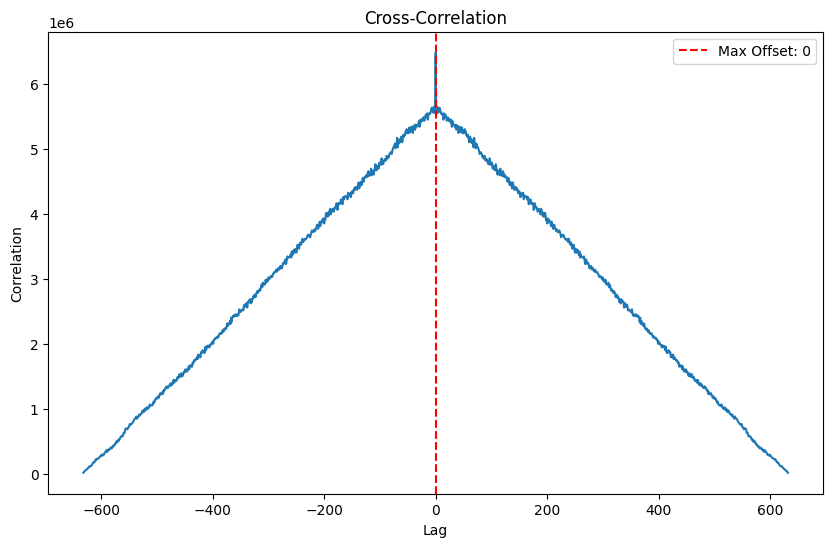

In [521]:
# Example time series (replace with your actual data)
from scipy.signal import correlate


time_series_1 = np.diff(onix_digital_array) # First time series
time_series_2 = np.diff(photometry_events_array)   # Second time series

# Cross-correlation
correlation = correlate(time_series_1, time_series_2, mode='full')
offset = np.argmax(correlation) - (len(time_series_2) - 1)

# Results
print("Offset at maximum correlation:", offset)

# Optional: Visualize the correlation

lags = np.arange(-len(time_series_2) + 1, len(time_series_1))
plt.figure(figsize=(10, 6))
plt.plot(lags, correlation)
plt.title("Cross-Correlation")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.axvline(x=offset, color='red', linestyle='--', label=f'Max Offset: {offset}')
plt.legend()
plt.show()

In [522]:
onix_digital_array

array([768974.09024 , 768977.380256, 768980.360256, 768984.73024 ,
       768987.215648, 768989.765536, 768993.265408, 768996.39024 ,
       769000.89024 , 769003.740256, 769006.79024 , 769010.120256,
       769011.564832, 769014.180256, 769017.19024 , 769019.997888,
       769021.520256, 769025.147712, 769027.77024 , 769029.897536,
       769033.380256, 769036.260256, 769041.25024 , 769045.31024 ,
       769047.79696 , 769052.246816, 769056.61024 , 769058.29024 ,
       769059.89024 , 769062.59648 , 769066.71024 , 769068.51024 ,
       769072.89024 , 769076.13024 , 769079.21024 , 769080.345888,
       769082.27024 , 769083.480256, 769084.51024 , 769089.295584,
       769092.760256, 769093.81024 , 769096.740256, 769097.960256,
       769099.180256, 769103.095104, 769106.340256, 769107.47024 ,
       769111.75024 , 769112.828064, 769115.611328, 769118.93024 ,
       769120.960256, 769124.77024 , 769126.827616, 769128.81088 ,
       769132.120256, 769136.060256, 769138.9272  , 769141.970

In [523]:
len(np.unique(np.diff(photometry_events_array)))

633

[]

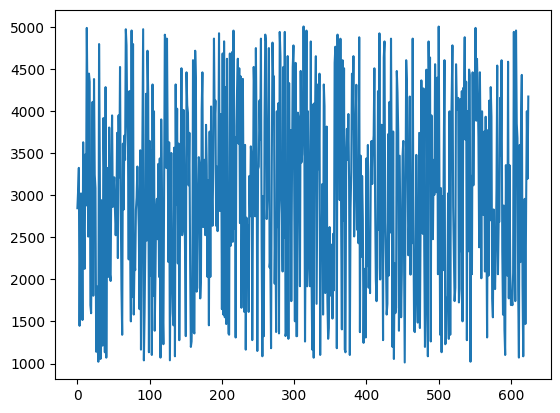

In [524]:
plt.plot(np.diff(photometry_events_array)[8:])
ax2.plot()
#plt.xlim([0,len(np.diff(photometry_events_array))])
#plt.xlim([168,200+168])
#plt.xlim([0,200])

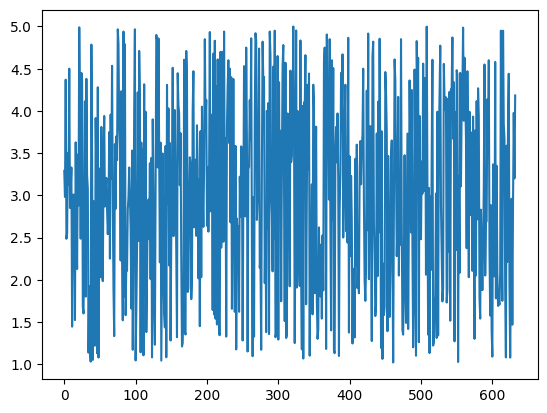

In [525]:
plt.plot(np.diff(onix_digital_array))
#plt.xlim([0, len(np.diff(onix_digital_array))-168])
#plt.xlim([0,200])
#plt.xlim([26,226])

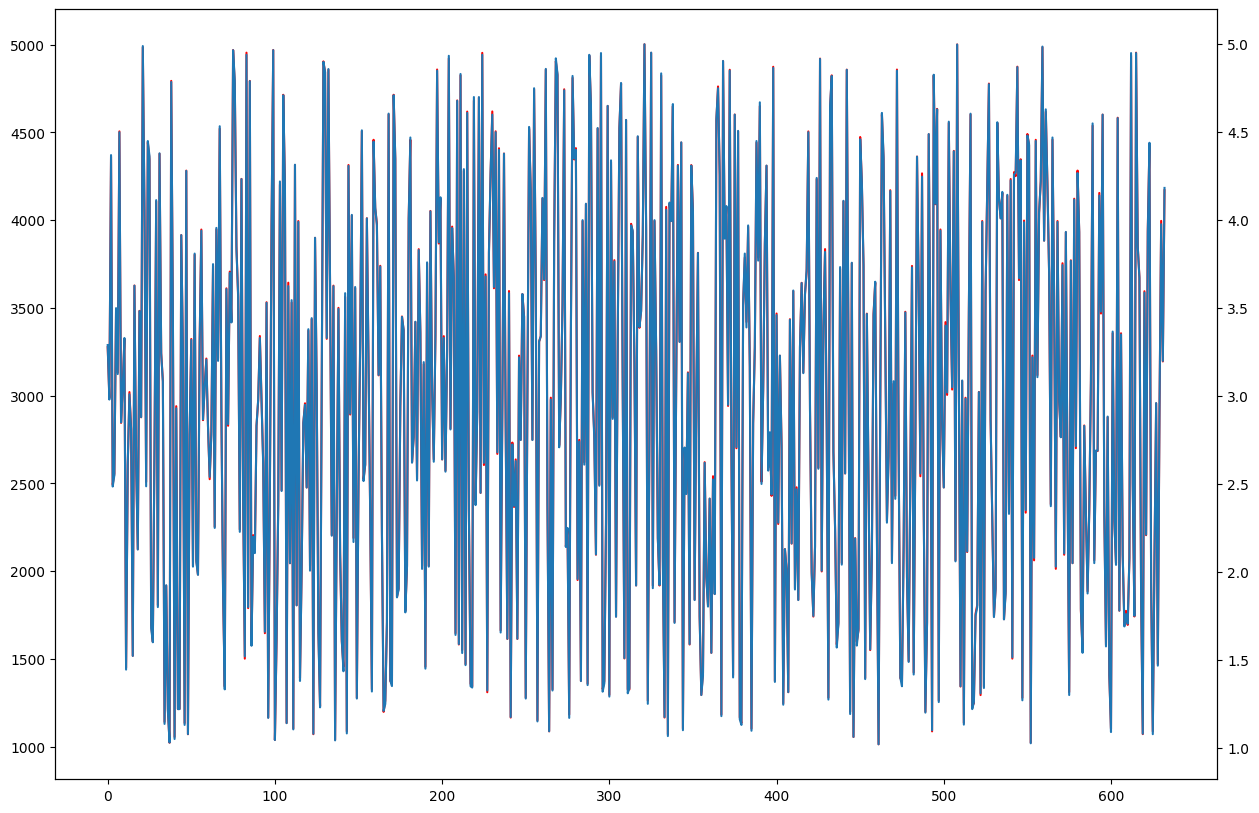

In [528]:
fig, ax1 = plt.subplots(figsize=(15,10))
ax2 = ax1.twinx()
if offset > 0:
    ax2.plot(np.diff(onix_digital_array[:offset]))
    ax1.plot(np.diff(photometry_events_array), color = 'r')
if offset < 0:
    ax2.plot(np.diff(onix_digital_array))
    ax1.plot(np.diff(photometry_events_array[abs(offset):]), color = 'r')
if offset == 0:
    ax2.plot(np.diff(onix_digital_array))
    ax1.plot(np.diff(photometry_events_array), color = 'r')
#plt.xlim([0,200])

In [9]:
conversions = process.calculate_conversions_second_approach(data_paths[0], photometry_paths[0], verbose=False)
# After hardware ONIX clock implementation - this will have to be adapted
# Only photometry will need to be converted

NameError: name 'calculate_conversions_second_approach' is not defined

In [ ]:
streams = utils.load_registers(data_path)

Photometry = utils.read_fluorescence(photometry_path)
Photometry['HARP Timestamps'] = conversions['photometry_to_harp_time'](Photometry['TimeStamp'])

OnixAnalogClock = utils.read_OnixAnalogClock(data_path)
OnixAnalogData = utils.read_OnixAnalogData(data_path, binarise=True)
ExperimentEvents = utils.read_ExperimentEvents(data_path) 



photodiode_series = pd.Series(OnixAnalogData[:,0], index=conversions['onix_to_harp_timestamp'](OnixAnalogClock))

In [ ]:
# Adding Photometry, Eye Movements and Photodiode to the streams
streams = process.reformat_and_add_many_streams(streams, Photometry, 'Photometry', ['CH1-410', 'CH1-470', 'CH1-560'], index_column_name='HARP Timestamps')
streams = process.add_stream(streams, 'ONIX', photodiode_series, 'Photodiode')

In [ ]:
_ = process.get_timepoint_info(streams, print_all=True)
resampled_streams = process.pad_and_resample(streams, resampling_period='1 ms', method='linear')
_ = process.get_timepoint_info(resampled_streams, print_all=True)

In [ ]:
# Applying linear and angular conversion to Optical tracking sensor streams
# OpticalTrackingRead0X(46) converted to centimeters per second
# OpticalTrackingRead0Y(46) covnerted to degrees per second
resampled_streams['H1']['OpticalTrackingRead0X(46)'] = process.running_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0X(46)']*100)
resampled_streams['H1']['OpticalTrackingRead0Y(46)'] = process.rotation_unit_conversion(resampled_streams['H1']['OpticalTrackingRead0Y(46)'])

In [ ]:
print(type(resampled_streams['Photometry']['CH1-470']))
resampled_streams['Photometry']['CH1-470']

In [ ]:
streams_to_save_pattern = {'H1': ['OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)'], 'H2': ['Encoder(38)'], 'Photometry': ['CH1-410', 'CH1-470', 'CH1-560'], 'ONIX': ['Photodiode']}
streams_to_save_pattern
